In [1]:

import os
os.chdir("../../")

In [2]:

from pyomo2h5 import load_yaml
import numpy as np

from scipy.optimize import minimize_scalar

import matplotlib.pyplot as plt

from src.preplanning.preprocessing.utils import dimensionalise_coeffs, get_max_values
from underestimating_hyperplanes import (
    calculate_max_values,
)

In [3]:
!pwd

/home/breuer/ventilation_system/preplanning


In [22]:
def calculate_BEP(alpha, beta, Qmax):

    dp_n_max = lambda q: alpha[1]*q**2 + alpha[2]*q + alpha[3]

    P_el_n_max = lambda q: beta[1]*q**3 + beta[2]*q**2 + beta[3]*q + beta[4]+ beta[5]

    eta = lambda q: dp_n_max(q)*q/P_el_n_max(q)


    # Use scipy to find q that maximizes eta(q) in a given interval
    res = minimize_scalar(lambda q_val: -eta(q_val), bounds=(0, Qmax), method='bounded')

    # Extract results
    q_opt = res.x
    dp_opt = dp_n_max(q_opt)
    P_el_opt = P_el_n_max(q_opt)
    eta_opt = dp_opt*q_opt/P_el_opt

    # print(f"values @ BEP:\nvolume flow: {q_opt:.2f} m³/s\npressure rise: {dp_opt:.2f} Pa\npower consumption: {P_el_opt:.2f} W")

    return q_opt, dp_opt, P_el_opt, eta_opt


def get_BEP_from_dict(fan_dict, d):

    alpha = fan_dict["ansatz"]["pressure"]["o2"]["ansatz_param"]
    beta = fan_dict["ansatz"]["power"]["o3"]["ansatz_param"]

    max_values = get_max_values(fan_dict)

    alpha, beta = dimensionalise_coeffs(alpha, beta, d, max_values)

    max_values = calculate_max_values(alpha, beta)

    Qmax = max_values["q"]

    return calculate_BEP(alpha, beta, Qmax)

def get_n_max(fan_dict, d):
    rotational_speed = fan_dict["ansatz"]["rotational_speed"]["o1"]["ansatz_param"]
    return (rotational_speed[1]*d + rotational_speed[2])/60

def compute_sigma_delta(n_max, q_opt, dp_opt, d):
    rho = 1.2
    sigma = n_max * np.sqrt(q_opt*np.pi)/(2*dp_opt/rho)**(3/4)
    sigma = n_max / (2*np.pi**2)**(-1/4) / (dp_opt/rho)**(3/4) / (q_opt)**(-1/2)

    delta = d * (2*dp_opt/rho/q_opt**2)**(1/4)*np.sqrt(np.pi)/2
    delta = d / (8/np.pi**2)**(1/4) / (dp_opt/rho)**(-1/4) / (q_opt)**(1/2)
    return sigma, delta

[np.float64(1.85544394893569), np.float64(1.8568963251039687)]
[np.float64(2.451171315646298), np.float64(2.4511713156462887)]
[np.float64(1.8364541412142064), np.float64(1.8370215054498173), np.float64(1.837289264188014), np.float64(1.837421695488343), np.float64(1.8374911336566135), np.float64(1.8375296260069385)]


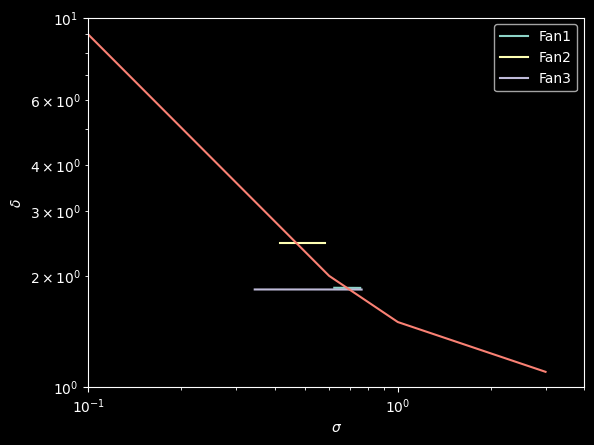

In [28]:
Fans = [("Fan1",0.3),("Fan1",0.5), ("Fan2",0.2), ("Fan2",0.4), ("Fan3",0.6),("Fan3",1.1)]

Fans = {"Fan1": [0.3,0.5], "Fan2": [0.2,0.4], "Fan3": [0.6, 1.1]}

for fan_name in Fans:
    max_diameters = Fans[fan_name]
    diameters = np.arange(max_diameters[0],max_diameters[1],0.1)
    sigmas, deltas = [], []
    for diameter in diameters:
        # print(fan_name, diameter)
        fan_dict = load_yaml(f"data/fan_data/{fan_name}.yml")
        q_opt, dp_opt, P_el_opt, eta_opt = get_BEP_from_dict(fan_dict, diameter)
        # print(eta_opt)

        n_max = get_n_max(fan_dict, diameter)

        sigma, delta = compute_sigma_delta(n_max, q_opt, dp_opt, diameter)
        sigmas.append(sigma)
        deltas.append(delta)
    plt.plot(sigmas, deltas, label=(fan_name))
    print(deltas)


x = np.logspace(-1,np.log10(4),100)
# plt.plot(x,1/x)
# plt.plot(x,1/x**3)
plt.plot([0.1,0.6,1,3],[9,2,1.5,1.1])

plt.ylim(1,10)
plt.xlim(0.1,4)

# plt.axvline(1)

plt.xlabel("$\sigma$")
plt.ylabel("$\delta$")


plt.legend()
plt.xscale("log")
plt.yscale("log")

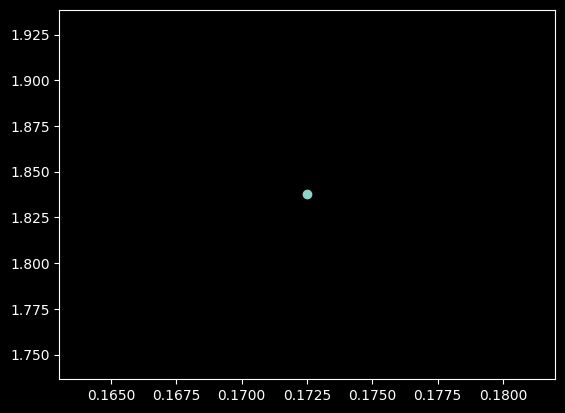

In [6]:

plt.scatter(sigma, delta)

x = np.logspace(-1,4,100)

# plt.plot(x,1/x)
# plt.plot(x,1/x**3)

# plt.xscale("log")
# plt.yscale("log")

In [7]:
x= np.linspace(0,100,100)



In [8]:
q_opt, eta_opt

(np.float64(21.999376762448396), np.float64(0.7402557033218418))